# Contexto

Las PBMC (células mononucleares de sangre periférica) incluyen linfocitos T, B, NK y monocitos. Son datasets clásicos en single-cell por su diversidad celular, lo que los hace ideales para practicar control de calidad (QC), clustering, anotación e integración.

## Datos

PBMC 1k (v3 chemistry):

- pbmc_1k_v3_filtered_feature_bc_matrix.h5 (https://cf.10xgenomics.com/samples/cell-exp/3.0.0/pbmc_1k_v3/pbmc_1k_v3_filtered_feature_bc_matrix.h5)
- pbmc_1k_v3_filtered_feature_bc_matrix.tar.gz (https://cf.10xgenomics.com/samples/cell-exp/3.0.0/pbmc_1k_v3/pbmc_1k_v3_filtered_feature_bc_matrix.tar.gz)

PBMC 10k (v3 chemistry):

- pbmc_10k_v3_filtered_feature_bc_matrix.h5 (https://cf.10xgenomics.com/samples/cell-exp/3.0.0/pbmc_10k_v3/pbmc_10k_v3_filtered_feature_bc_matrix.h5)
- pbmc_10k_v3_filtered_feature_bc_matrix.tar.gz (https://cf.10xgenomics.com/samples/cell-exp/3.0.0/pbmc_10k_v3/pbmc_10k_v3_filtered_feature_bc_matrix.tar.gz)

PBMC 20k (Chromium X, HT):

- 20k_PBMC_3p_HT_nextgem_Chromium_X_filtered_feature_bc_matrix.h5 (https://cf.10xgenomics.com/samples/cell-exp/6.1.0/20k_PBMC_3p_HT_nextgem_Chromium_X/20k_PBMC_3p_HT_nextgem_Chromium_X_filtered_feature_bc_matrix.h5)
- 20k_PBMC_3p_HT_nextgem_Chromium_X_filtered_feature_bc_matrix.tar.gz (https://cf.10xgenomics.com/samples/cell-exp/6.1.0/20k_PBMC_3p_HT_nextgem_Chromium_X/20k_PBMC_3p_HT_nextgem_Chromium_X_filtered_feature_bc_matrix.tar.gz)


# PBMC 1k

In [1]:
# Core scverse libraries
from __future__ import annotations

import anndata as ad

import pandas as pd

import numpy as np

# Data retrieval
import scanpy as sc

import scvi

import os

import torch

/Users/fabro/Documents/UBA/TESIS/repos/single-cell/ambiente/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Carga de datos & Naming

Usamos `var_names_make_unique` y `obs_names_make_unique` para que cuando juntemos samples distintas no nos equivoquemos e integremos información de distintas células.

In [2]:
samples = {
    "pbmc_1k": "pbmc_1k_v3_filtered_feature_bc_matrix.h5",
    "pbmc_20k": "PBMC 3p HT NextGem Analysis.h5"
}

adatas = {}

for sample_id, filename in samples.items():
    path = f'../assets/{sample_id}/{filename}'
    
    data = sc.read_10x_h5(path)
    
    data.var_names_make_unique()
    data.obs_names_make_unique()
    
    adatas[sample_id] = data

adata = ad.concat(
    adatas,
    label="sample",
    join="outer",
    index_unique="-"
)


adata.obs_names_make_unique()

print(adata.obs["sample"].value_counts())
adata


/Users/fabro/Documents/UBA/TESIS/repos/single-cell/ambiente/lib/python3.11/site-packages/anndata/_core/anndata.py:1825: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/Users/fabro/Documents/UBA/TESIS/repos/single-cell/ambiente/lib/python3.11/site-packages/anndata/_core/anndata.py:1825: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/Users/fabro/Documents/UBA/TESIS/repos/single-cell/ambiente/lib/python3.11/site-packages/anndata/_core/anndata.py:1825: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/Users/fabro/Documents/UBA/TESIS/repos/single-cell/ambiente/lib/python3.11/site-packages/anndata/_core/anndata.py:1825: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplic

sample
pbmc_20k    23837
pbmc_1k      1222
Name: count, dtype: int64


AnnData object with n_obs × n_vars = 25059 × 38224
    obs: 'sample'

## QC Control

In [3]:
# mitochondrial genes, "MT-" for human, "Mt-" for mouse
adata.var["mt"] = adata.var_names.str.startswith("MT-")

# ribosomal genes
adata.var["ribo"] = adata.var_names.str.startswith(("RPS", "RPL"))

# hemoglobin genes
adata.var["hb"] = adata.var_names.str.contains("^HB[^(P)]")

In [4]:
sc.pp.calculate_qc_metrics(adata, qc_vars=["mt", "ribo", "hb"], inplace=True, log1p=True)

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


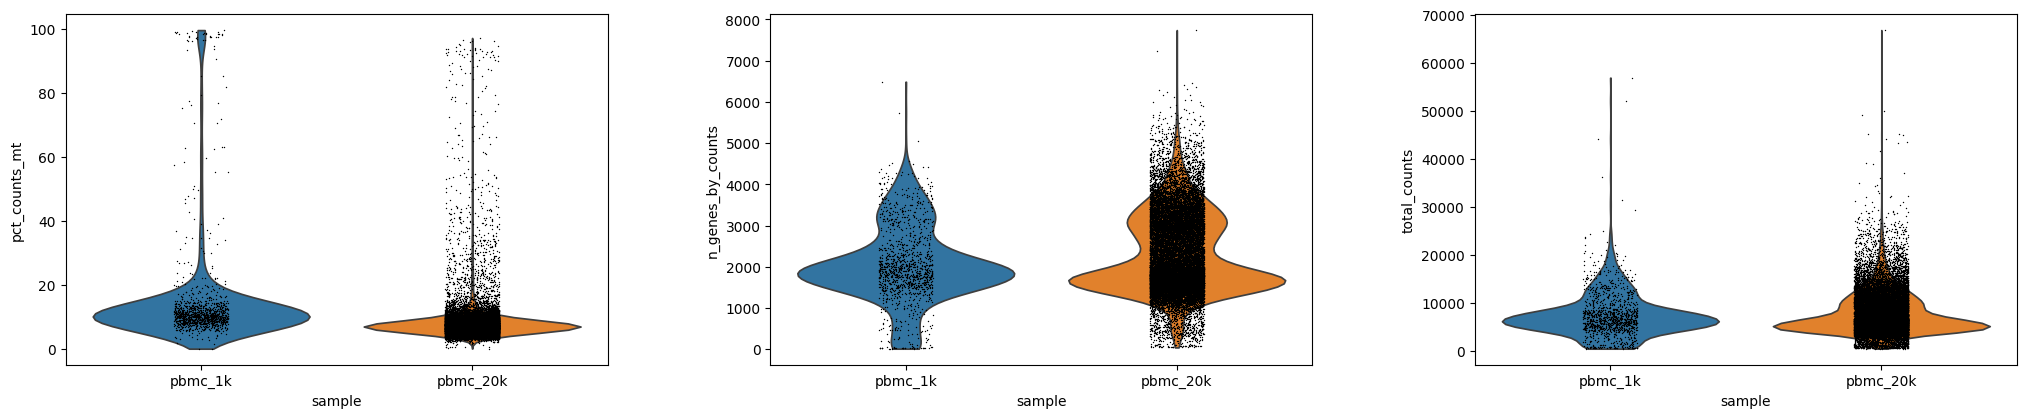

In [5]:
sc.pl.violin(adata, ["pct_counts_mt", "n_genes_by_counts", "total_counts"], groupby="sample")

### QC de HB

QC-HB: El porcentaje se calcula como la proporción de UMIs asignadas a genes de hemoglobina sobre el total de UMIs por célula.

La HB mide la hemoglobina, en este estudio en particular de PBMC no se consideran eritroblastos/eritrocitos las cuales son células que generan hemoglobina. Una prueba de pureza es la de controlar el Pct de HB contenida en las células y un Pct alto indicaría una potencial contaminación.

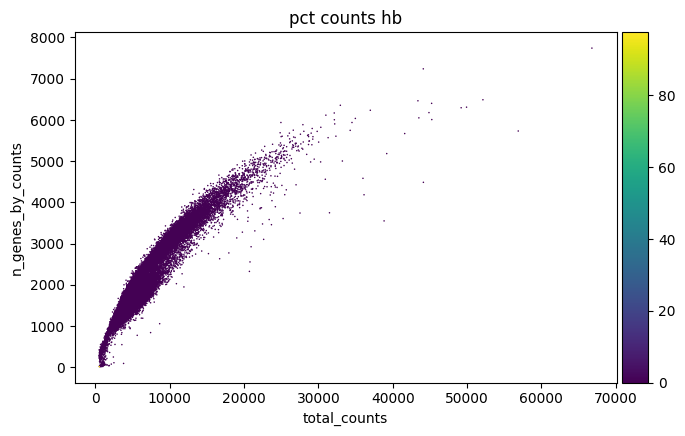

In [6]:
sc.pl.scatter(adata, "total_counts", "n_genes_by_counts", color="pct_counts_hb")

## Filtrado del set

Parametros importantes que encontré, los valores son súper ad-hoc al problema que estamos analizando


**min_genes=100** permite reducir droplets (gotas de aceite) vacías o células dañadas (es un hiperparámetro)

**min_cells=3** permite reducir genes extremadamente raros que aportan poco a la variabilidad biológica.

In [7]:
sc.pp.filter_cells(adata, min_genes=300)
sc.pp.filter_genes(adata, min_cells=3)
adata = adata[adata.obs['pct_counts_mt'] < 15, :]

In [8]:
adata

View of AnnData object with n_obs × n_vars = 24061 × 24517
    obs: 'sample', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'n_genes'
    var: 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells'
    uns: 'sample_colors'

Pasamos de `n_obs × n_vars = 1222 × 33538` a `n_obs × n_vars = 1185 × 15247` lo cual implica que ~40 células tenían menos de 100 genes detectados, y habian ~15k genes que se detectaron en menos de 3 células.

## Detección de Doublets

Scanpy usa Scrublet como algoritmo de detección de doublets, que es el fenomeno que ocurre cuando dos o más células quedan encapsuladas en la misma droplet.

Necesitamos procesarlas porque sino genera perfiles de expresión irreales

In [9]:
sc.pp.scrublet(adata, batch_key="sample")
adata

AnnData object with n_obs × n_vars = 24061 × 24517
    obs: 'sample', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'n_genes', 'doublet_score', 'predicted_doublet'
    var: 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells'
    uns: 'sample_colors', 'scrublet'

In [10]:
adata = adata[~adata.obs['predicted_doublet']].copy()
adata

AnnData object with n_obs × n_vars = 22891 × 24517
    obs: 'sample', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'n_genes', 'doublet_score', 'predicted_doublet'
    var: 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells'
    uns: 'sample_colors', 'scrublet'

## Normalización

Operaciones sobre los counts de los datos para por ejemplo ajustar los conteos de cada célula para corregir diferencias en el tamaño de la biblioteca (library size), es decir, en el número total de UMIs detectadas por célula.

Se aplica una transformación logarítmica para estabilizar la varianza.

In [11]:
# persistimos la info

adata.layers["counts"] = adata.X.copy()

In [12]:
# Normalizing to median total counts
sc.pp.normalize_total(adata, target_sum=1e4)

# Logarithmize the data
sc.pp.log1p(adata)

In [13]:
adata.obs

,sample,n_genes_by_counts,log1p_n_genes_by_counts,total_counts,log1p_total_counts,pct_counts_in_top_50_genes,pct_counts_in_top_100_genes,pct_counts_in_top_200_genes,pct_counts_in_top_500_genes,total_counts_mt,...,pct_counts_mt,total_counts_ribo,log1p_total_counts_ribo,pct_counts_ribo,total_counts_hb,log1p_total_counts_hb,pct_counts_hb,n_genes,doublet_score,predicted_doublet
AAACCCAAGGAGAGTA-1-pbmc_1k,pbmc_1k,2620,7.871311,8288.0,9.022685,35.291988,44.570463,54.174710,67.410714,893.0,...,10.774614,1047.0,6.954639,12.632722,0.0,0.000000,0.000000,2618,0.037975,False
AAACGCTTCAGCCCAG-1-pbmc_1k,pbmc_1k,1808,7.500529,5512.0,8.614864,39.314224,54.499274,63.969521,75.834543,439.0,...,7.964441,1776.0,7.482682,32.220612,1.0,0.693147,0.018142,1805,0.010130,False
AAAGAACAGACGACTG-1-pbmc_1k,pbmc_1k,1562,7.354362,4283.0,8.362642,39.084754,51.482606,61.592342,75.204296,265.0,...,6.187252,1190.0,7.082549,27.784264,0.0,0.000000,0.000000,1559,0.025641,False
AAAGAACCAATGGCAG-1-pbmc_1k,pbmc_1k,1225,7.111512,2754.0,7.921173,36.419753,47.240378,58.351489,73.674655,165.0,...,5.991285,638.0,6.459905,23.166304,0.0,0.000000,0.000000,1225,0.020258,False
AAAGAACGTCTGCAAT-1-pbmc_1k,pbmc_1k,1831,7.513164,6592.0,8.793764,42.854976,58.131068,67.763956,78.534587,436.0,...,6.614078,2475.0,7.814400,37.545509,0.0,0.000000,0.000000,1827,0.032407,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTTGTTGGTTCAAGGG-1-pbmc_20k,pbmc_20k,1541,7.340836,5318.0,8.579041,44.283565,60.116585,68.804062,80.424972,271.0,...,5.095901,2216.0,7.703910,41.669800,1.0,0.693147,0.018804,1541,0.015758,False
TTTGTTGTCACCTGGG-1-pbmc_20k,pbmc_20k,1880,7.539559,5073.0,8.531885,36.842105,49.339641,58.249556,71.358171,345.0,...,6.800710,1458.0,7.285507,28.740391,0.0,0.000000,0.000000,1880,0.020188,False
TTTGTTGTCATTGAGC-1-pbmc_20k,pbmc_20k,1696,7.436617,6433.0,8.769352,44.893518,62.319291,70.666874,81.019742,331.0,...,5.145344,2995.0,8.005033,46.556816,0.0,0.000000,0.000000,1696,0.039326,False
TTTGTTGTCCGATGTA-1-pbmc_20k,pbmc_20k,3787,8.239593,12527.0,9.435721,26.383013,35.906442,45.964716,59.399697,777.0,...,6.202602,1858.0,7.527794,14.831964,0.0,0.000000,0.000000,3787,0.028384,False


## Feature Selection

Queremos quedarnos con los genes mas informativos y esto lo hacemos con `pp.highly_variable_genes`

In [14]:
sc.pp.highly_variable_genes(adata, n_top_genes=2000, batch_key="sample")

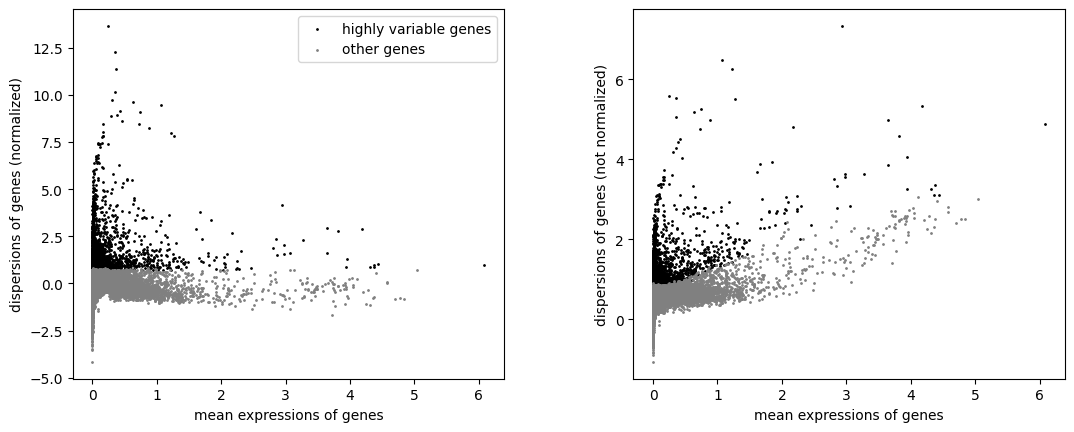

In [15]:
sc.pl.highly_variable_genes(adata)

## Dimensionality Reduction

In [16]:
sc.tl.pca(adata)

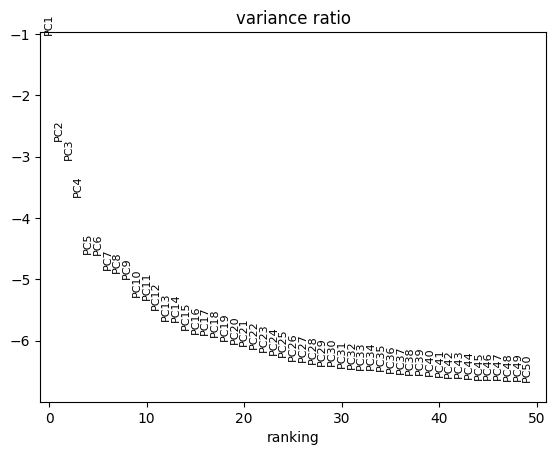

In [17]:
sc.pl.pca_variance_ratio(adata, n_pcs=50, log=True)

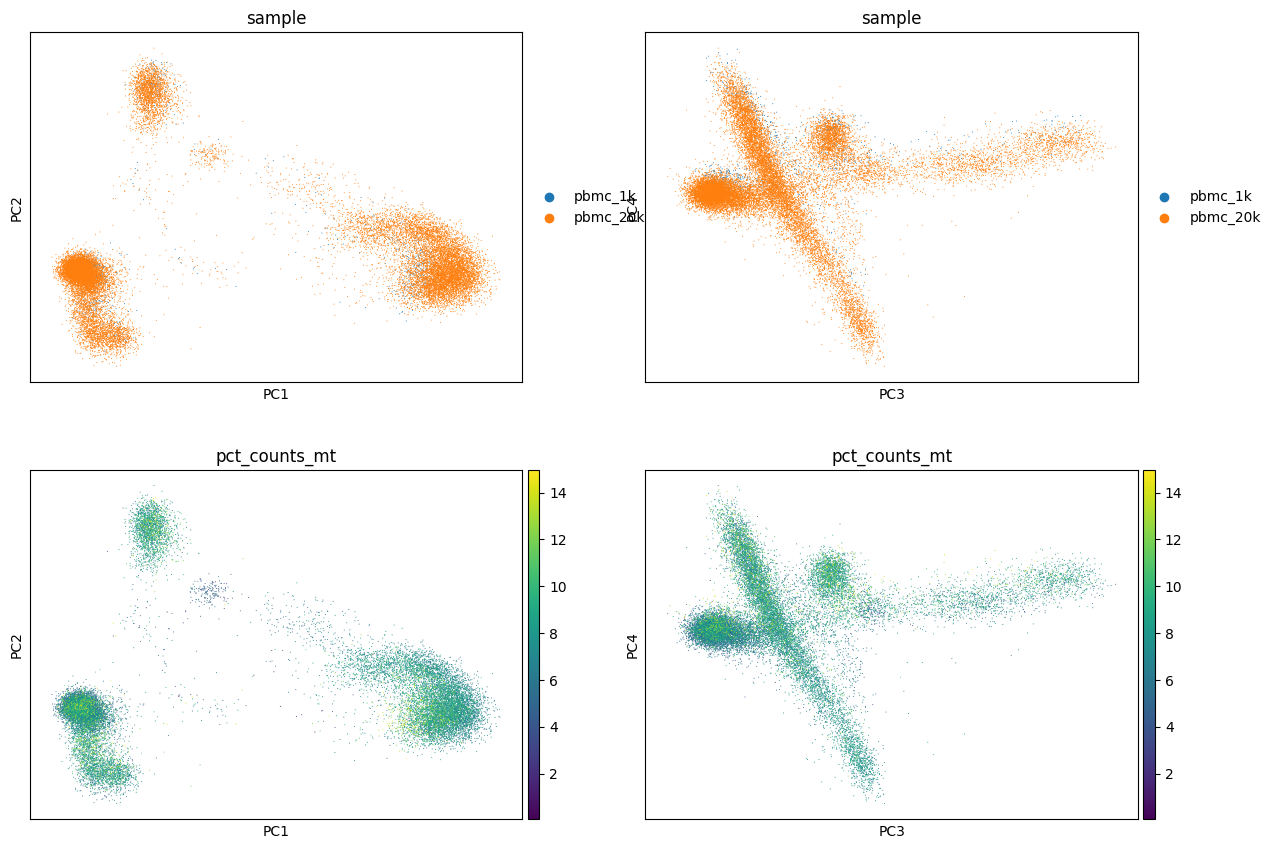

In [18]:
sc.pl.pca(
    adata,
    color=["sample", "sample", "pct_counts_mt", "pct_counts_mt"],
    dimensions=[(0, 1), (2, 3), (0, 1), (2, 3)],
    ncols=2,
    size=2,
)

In [19]:
sc.pp.neighbors(adata)

In [20]:
sc.tl.umap(adata)

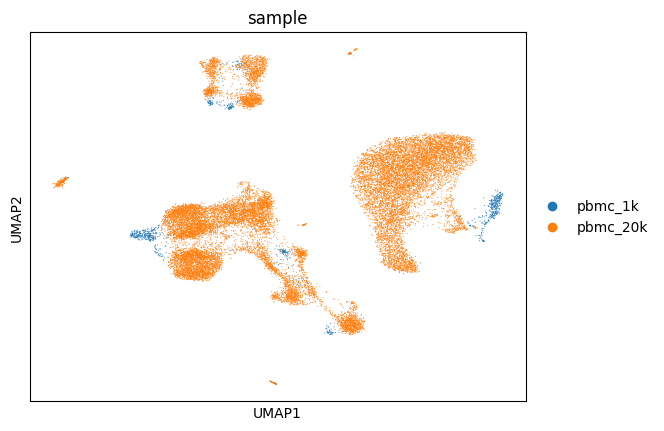

In [21]:
sc.pl.umap(
    adata,
    color="sample",
    # Setting a smaller point size to get prevent overlap
    size=2,
)

## Clustering

In [22]:
sc.tl.leiden(adata, flavor="igraph", n_iterations=2)

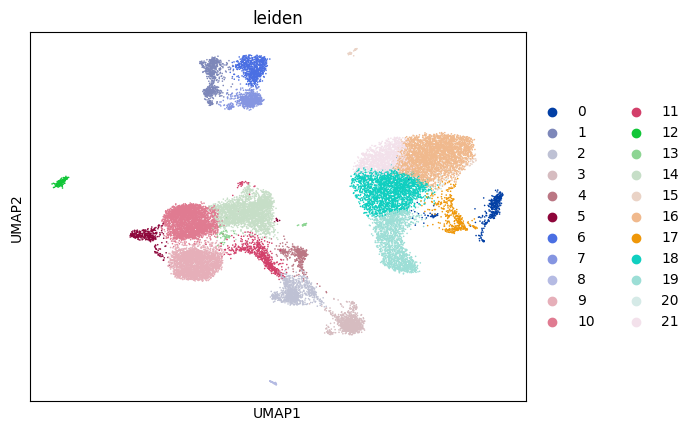

In [23]:
sc.pl.umap(adata, color=["leiden"])

In [24]:
for res in [0.02, 0.5, 2.0]:
    sc.tl.leiden(adata, key_added=f"leiden_res_{res:4.2f}", resolution=res, flavor="igraph")

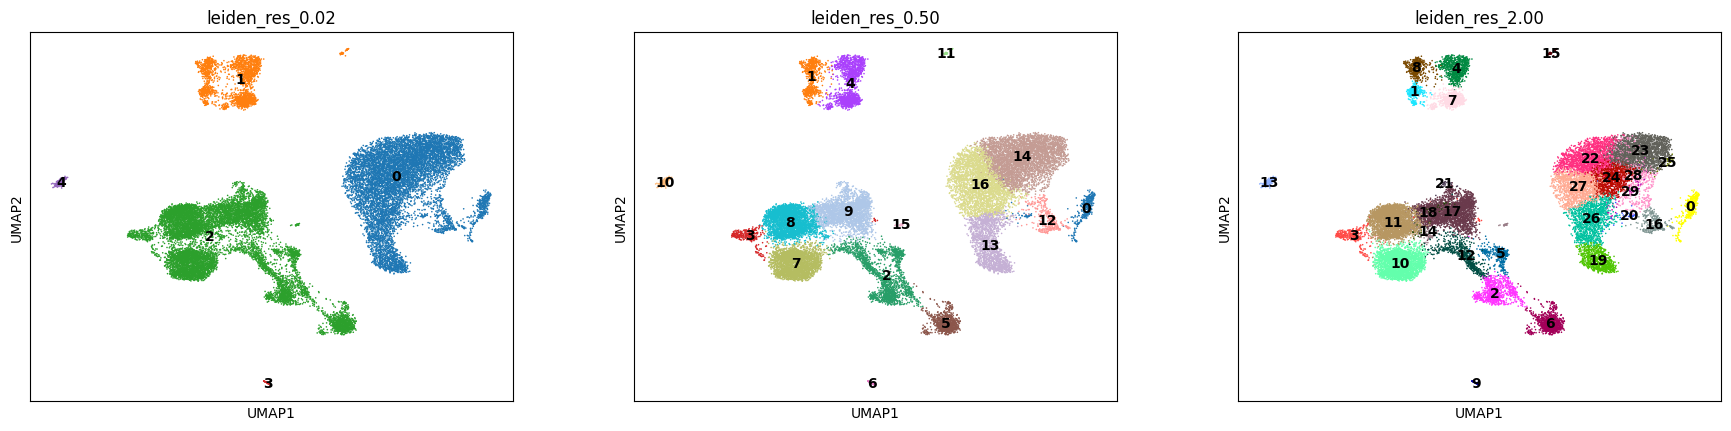

In [25]:
sc.pl.umap(
    adata,
    color=["leiden_res_0.02", "leiden_res_0.50", "leiden_res_2.00"],
    legend_loc="on data",
)

## Cell Label

In [26]:
marker_genes_pbmc = {
    "T cells": ["CD3D", "CD3E", "TRAC"],
    "CD4 T": ["IL7R", "CCR7", "LTB"],
    "CD8 T / cytotoxic": ["NKG7", "GNLY", "GZMB", "PRF1"],
    "NK cells": ["NKG7", "GNLY", "FCGR3A", "TYROBP"],
    "B cells": ["MS4A1", "CD79A", "CD74", "HLA-DRA"],
    "Plasma": ["MZB1", "XBP1", "JCHAIN", "IGHG1"],
    "Monocytes (CD14+)": ["LYZ", "S100A8", "S100A9", "LGALS3", "CTSS"],
    "Monocytes (FCGR3A+)": ["LYZ", "FCGR3A", "MS4A7", "LST1"],
    "Dendritic": ["FCER1A", "CST3"],
    "Megakaryocytes": ["PPBP", "PF4"],
}


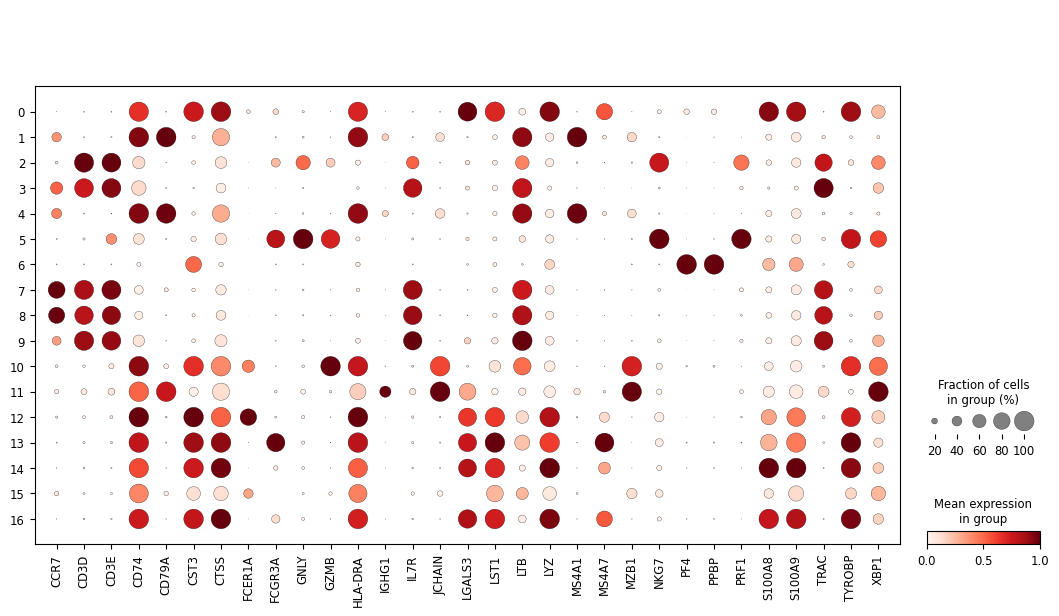

In [27]:
genes = sorted({g for gs in marker_genes_pbmc.values() for g in gs})
genes = [g for g in genes if g in adata.var_names]

sc.pl.dotplot(
    adata,
    genes,
    groupby="leiden_res_0.50",
    standard_scale="var"
)


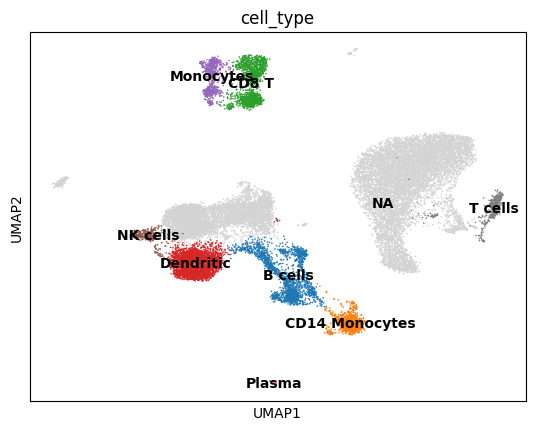

In [28]:
cluster_to_celltype = {
    "0": "T cells",
    "1": "Monocytes",
    "2": "B cells",
    "3": "NK cells",
    "4": "CD8 T",
    "5": "CD14 Monocytes",
    "6": "Plasma",
    "7": "Dendritic"
}

adata.obs["cell_type"] = adata.obs["leiden_res_0.50"].map(cluster_to_celltype).astype("category")

sc.pl.umap(adata, color="cell_type", legend_loc="on data")



In [29]:
labels_path = '../assets/CellMarker/PBMC_labels.csv'
cm = pd.read_csv(labels_path)

cm.columns

Index(['Species', 'Tissue Class', 'Tissue Type', 'Cancer', 'Cell name',
       'Cell marker', 'Source', 'Supports', 'Detail'],
      dtype='object')

### CellMarker 2.0

In [30]:
cm_pbmc = cm[
    (cm["Species"] == "Human") &
    (cm["Cancer"] == "Normal cell") &
    (cm["Tissue Type"].str.contains("Blood|PBMC|Peripheral blood", case=False, na=False))
]

### Manual Marker

In [31]:
marker_lvl1 = {
    "T cells": ["CD3D", "CD3E", "TRAC"],
    "NK cells": ["NKG7", "GNLY", "KLRD1"],
    "B cells": ["MS4A1", "CD79A", "CD74"],
    "Plasma": ["MZB1", "XBP1", "JCHAIN"],
    "Monocytes": ["LYZ", "S100A8", "S100A9", "LGALS3"],
    "Dendritic": ["FCER1A", "CST3"],
    "Megakaryocytes": ["PPBP", "PF4"]
}


In [32]:
marker_lvl1 = {
    ct: [g for g in genes if g in adata.var_names]
    for ct, genes in marker_lvl1.items()
}


In [33]:
for ct, genes in marker_lvl1.items():
    if len(genes) >= 2:
        sc.tl.score_genes(
            adata,
            gene_list=genes,
            score_name=f"score_{ct}"
        )


In [34]:
cluster_key = "leiden_res_0.50"

score_cols = [c for c in adata.obs.columns if c.startswith("score_")]

cluster_scores = adata.obs.groupby(cluster_key)[score_cols].mean()

cluster_to_label = (
    cluster_scores.idxmax(axis=1)
    .str.replace("score_", "", regex=False)
)

adata.obs["cell_type_lvl1"] = (
    adata.obs[cluster_key]
    .map(cluster_to_label)
    .astype("category")
)


/var/folders/hh/mk5t3ptd1dv1dl8j2kf1wj0r0000gn/T/ipykernel_31850/1879672778.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  cluster_scores = adata.obs.groupby(cluster_key)[score_cols].mean()


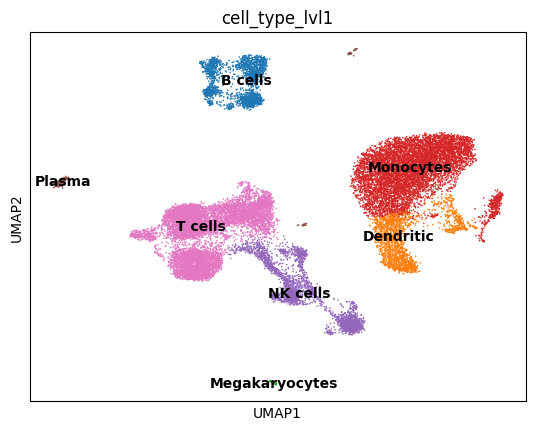

In [35]:
sc.pl.umap(
    adata,
    color="cell_type_lvl1",
    legend_loc="on data"
)


# Vamo con scVI

Sigo el entrenamiento [en Colab](https://colab.research.google.com/drive/1UWyIVsbGASUXUTyd3H6uP-Of6MhFleQd?authuser=0#scrollTo=M2vO1Wa5j8j3) ya que disponemos de una GPU (en Mac sc-vi no se anda :())

In [36]:
adata.write_h5ad("../export/adata_pre_scvi.h5ad")

In [37]:
# adata = sc.read_h5ad("../export/adata_pre_scvi.h5ad")

In [38]:
scVI_path = '../assets/scVI'

model = scvi.model.SCVI.load(scVI_path, adata=adata)

INFO     File ../assets/scVI/model.pt already downloaded                                                           


/Users/fabro/Documents/UBA/TESIS/repos/single-cell/ambiente/lib/python3.11/site-packages/scvi/model/base/_base_model.py:857: UserWarning: `accelerator` has been automatically set to `cpu` although 'mps' exists. If you wish to run on mps backend, use explicitly accelerator='mps' in train function.In future releases it will become default for mps supported machines.
  _, _, device = parse_device_args(
/Users/fabro/Documents/UBA/TESIS/repos/single-cell/ambiente/lib/python3.11/site-packages/scvi/model/base/_base_model.py:894: UserWarning: `var_names` for the loaded `model` does not match those used to train the model. For valid results, the former should match the latter.
  _validate_var_names(adata, var_names)


ValueError: Number of vars in `adata_target` not the same as source. Expected: 24519 Received: 24517

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


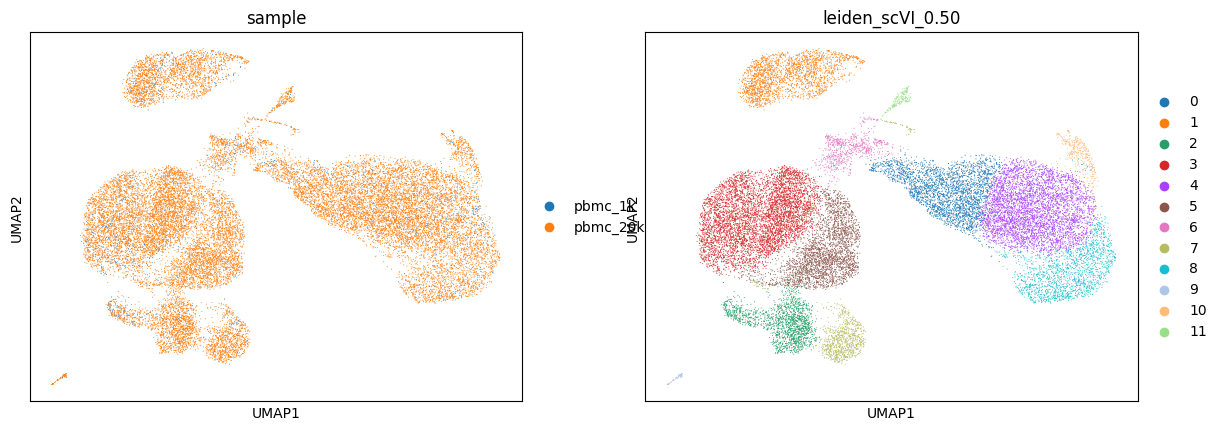

In [ ]:

# Extraemos la representación latente
adata.obsm["X_scVI"] = model.get_latent_representation()

# Recalculamos vecinos y UMAP con el nuevo espacio
sc.pp.neighbors(adata, use_rep="X_scVI")
sc.tl.umap(adata)
sc.tl.leiden(adata, flavor="igraph", resolution=0.50, key_added="leiden_scVI_0.50")

# Vemos el resultado
sc.pl.umap(adata, color=["sample", "leiden_scVI_0.50"], ncols=2, size=2)

/var/folders/hh/mk5t3ptd1dv1dl8j2kf1wj0r0000gn/T/ipykernel_30938/3453830238.py:50: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(cluster_key)[score_cols]


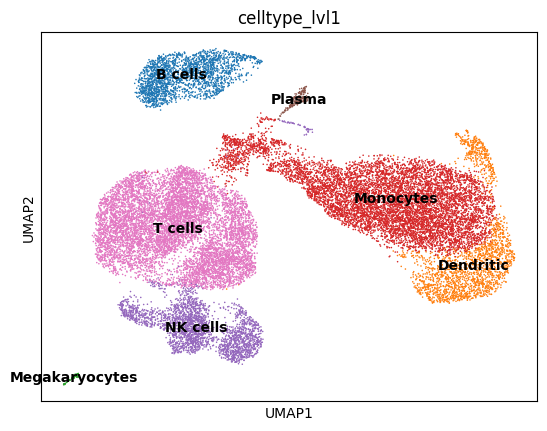

In [ ]:

marker_lvl1 = {
    "T cells": ["CD3D", "CD3E", "TRAC"],
    "NK cells": ["NKG7", "GNLY", "KLRD1"],
    "B cells": ["MS4A1", "CD79A", "CD74"],
    "Plasma": ["MZB1", "XBP1", "JCHAIN"],
    "Monocytes": ["LYZ", "S100A8", "S100A9", "LGALS3"],
    "Dendritic": ["FCER1A", "CST3"],
    "Megakaryocytes": ["PPBP", "PF4"]
}

# Filtrar genes que existan en el dataset

marker_lvl1 = {
    ct: [g for g in genes if g in adata.var_names]
    for ct, genes in marker_lvl1.items()
}

#Calcular score por tipo celular

for ct, genes in marker_lvl1.items():
    if len(genes) >= 2:  # mínimo 2 genes
        sc.tl.score_genes(
            adata,
            gene_list=genes,
            score_name=f"score_{ct}"
        )

# Promedio de score por cluster

cluster_key = "leiden_scVI_0.50"

score_cols = [c for c in adata.obs.columns if c.startswith("score_")]

cluster_scores = (
    adata.obs
    .groupby(cluster_key)[score_cols]
    .mean()
)

# Asignar mejor label a cada cluster

cluster_annotation = cluster_scores.idxmax(axis=1)
cluster_annotation = cluster_annotation.str.replace("score_", "")

# Mapear label a cada célula

adata.obs["celltype_lvl1"] = adata.obs[cluster_key].map(cluster_annotation)

sc.pl.umap(
    adata,
    color=["celltype_lvl1"],
    legend_loc="on data"
)


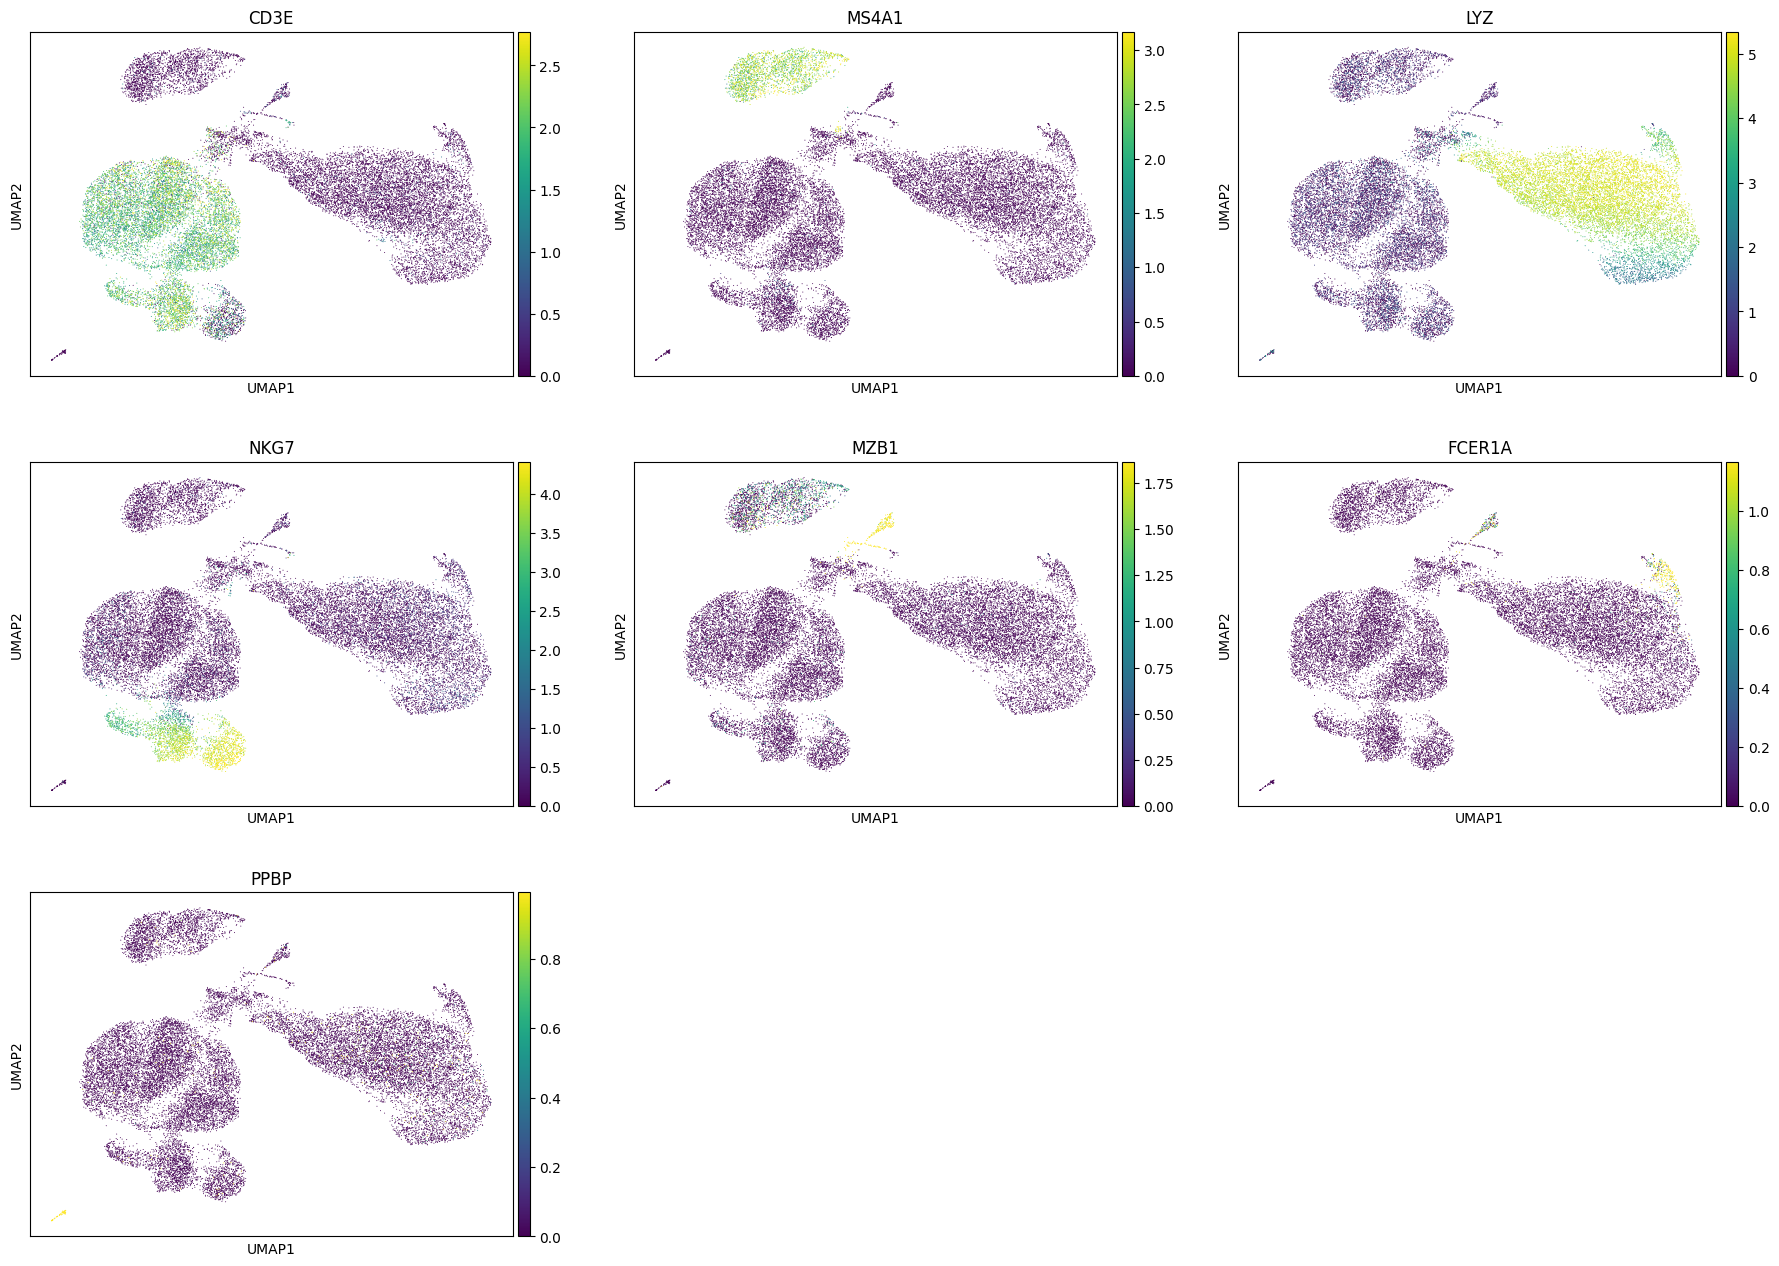

In [ ]:
# Genes bandera de cada linaje principal
genes_auditoria = [
    'CD3E',   # T cells
    'MS4A1',  # B cells (CD20)
    'LYZ',    # Monocytes
    'NKG7',   # NK cells
    'MZB1',   # Plasma
    'FCER1A', # Dendritic
    'PPBP'    # Megakaryocytes
]

# Ploteamos la expresión sobre el UMAP
sc.pl.umap(
    adata,
    color=genes_auditoria,
    cmap='viridis',     # Escala de colores (amarillo es alta expresión)
    vmax='p99',         # Corta el 1% de outliers altos para que no arruinen la escala visual
    ncols=3,
    size=2
)